# Dataload and Fillvalue

- credit risk
- 1 -> good
- 2 -> bad

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN

In [2]:
df = pd.read_csv("/kaggle/input/german-credit-data-set-with-credit-risk/german_credit_data_updated.csv", index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Credit Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,2
2,49,male,1,own,little,NaN,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,2


In [3]:
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     175
Checking account    378
Credit amount         0
Duration              0
Purpose               0
Credit Risk           0
dtype: int64

In [4]:
for col in ['Saving accounts', 'Checking account']:
    df[col].fillna('none', inplace=True)

In [5]:
#对Job进行热编码（One-Hot Encoding）
j = {0: 'unskilled and non-res', 1: 'unskilled and res', 2: 'skilled', 3: 'highly skilled'}
df['Job'] = df['Job'].map(j)

df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Credit Risk
0,67,male,skilled,own,none,little,1169,6,radio/TV,1
1,22,female,skilled,own,little,moderate,5951,48,radio/TV,2
2,49,male,unskilled and res,own,little,none,2096,12,education,1
3,45,male,skilled,free,little,little,7882,42,furniture/equipment,1
4,53,male,skilled,free,little,little,4870,24,car,2


# Data Analysis & Visualization

## 不同工作类型和性别的风险分布

- skilled（技术工人）更有可能获得“good”的风险评级。因为技术工人通常收入更高并且工作保障性更强。
- 在所有工作类型中，male获得“good”评级的概率远高于female。技术工女性被分类为“bad”的情况比“good”更常见。这暗示了制度性性别歧视的存在。

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


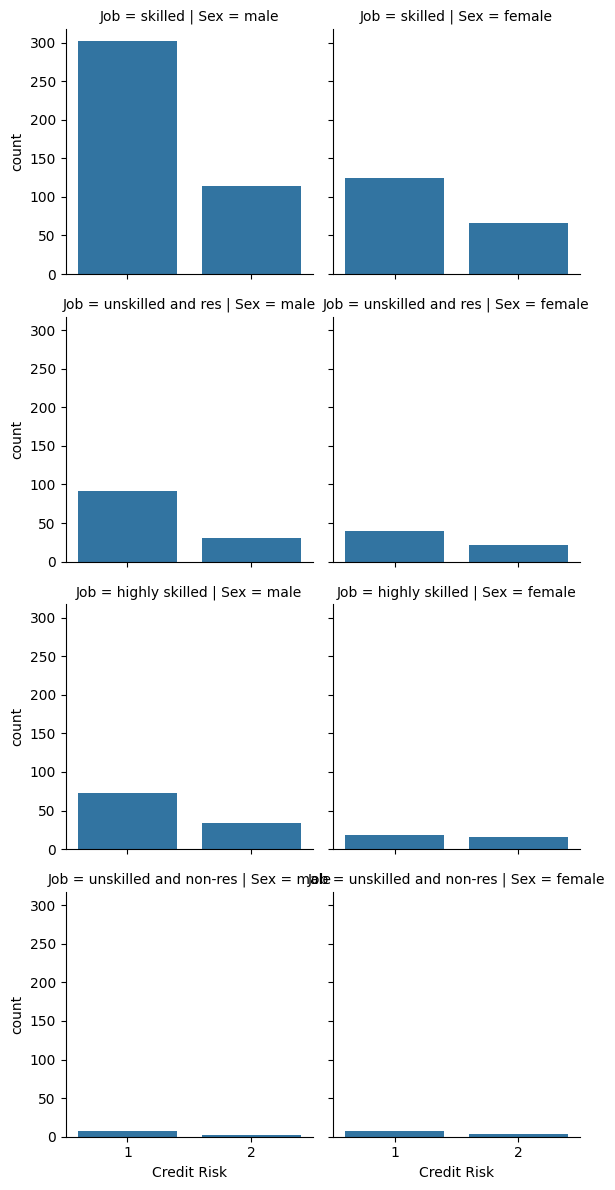

In [6]:
g = sns.FacetGrid(df, col="Sex",  row="Job")
g = g.map(sns.countplot, "Credit Risk")

## 不同住房状况的风险分布

- 'own'(拥有自己的住房)在信用评级中获得“good”风险评级的可能性比‘rent’的人更高。因为信用价值与资产所有权密切相关。

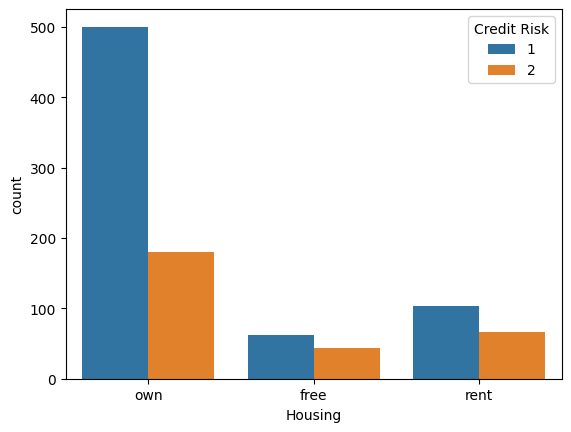

In [7]:
sns.countplot(x="Housing", hue="Credit Risk", data=df)
plt.show()

## 不同银行账户状态的风险分布

- 对于checking account来说，财富越多，被分类为“good”的可能性就越大。然而，当checking account状态为“none”的时候，“good”和“bad”风险评级之间的差距非常惊人。请记住，这些人在原始数据集中checking account列的值是“NaN”。
- 对于saving accounts来说，这一趋势同样成立。财富越多，被分类为“good”的可能性就越大。然而，与checking account不同的是，在checking account中，拥有“little”资金的人有相同的“good”和“bad”评级分布，而在saving accounts中，明显的“good”评级比“bad”评级更多。因为saving accounts的存在本身就意味着一定程度的财务安全。

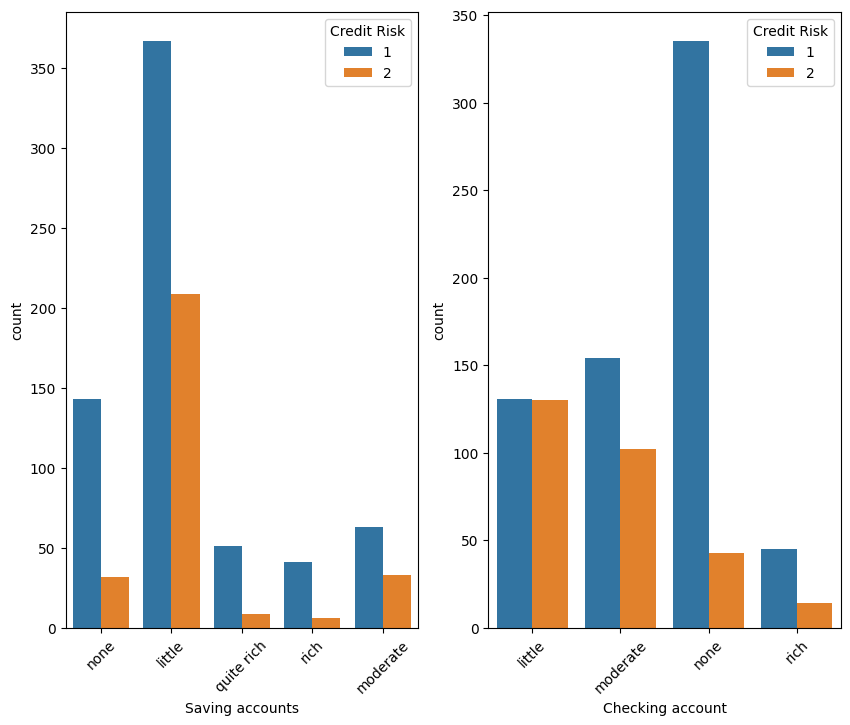

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8))
sns.countplot(x="Saving accounts", hue="Credit Risk", data=df, ax=ax1)
sns.countplot(x="Checking account", hue="Credit Risk", data=df, ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

fig.show()

## 各变量中信用额度分布的箱线图

### 按 Purpose 划分的 Credit Amount Distribution

- 某些 purposes（如 vacation/others 和 business loans）在贷款金额较高时更可能获得“bad”评级。
- 除 furniture/equipment 和 repairs 类别外，其他几乎所有类别的“bad”贷款 Credit Amounts 的四分位距通常更大。
- Radio/TV 类别有许多离群值，特别是被分类为“good”的贷款。

### 按 Bank Account Statuses 划分的 Amount Distributions

- 富人比穷人借款更少，这可能是因为穷人需要更多钱来满足需求。

### 按 Job Types 划分的 Amount Distributions

- 'skilled'(技术工人)的“bad”贷款金额和 IQR（四分位距）较大，这可能是因为较大金额的贷款更可能被分类为“bad”。
- 'unskilled'(非技术工人)中，这种差异不明显。

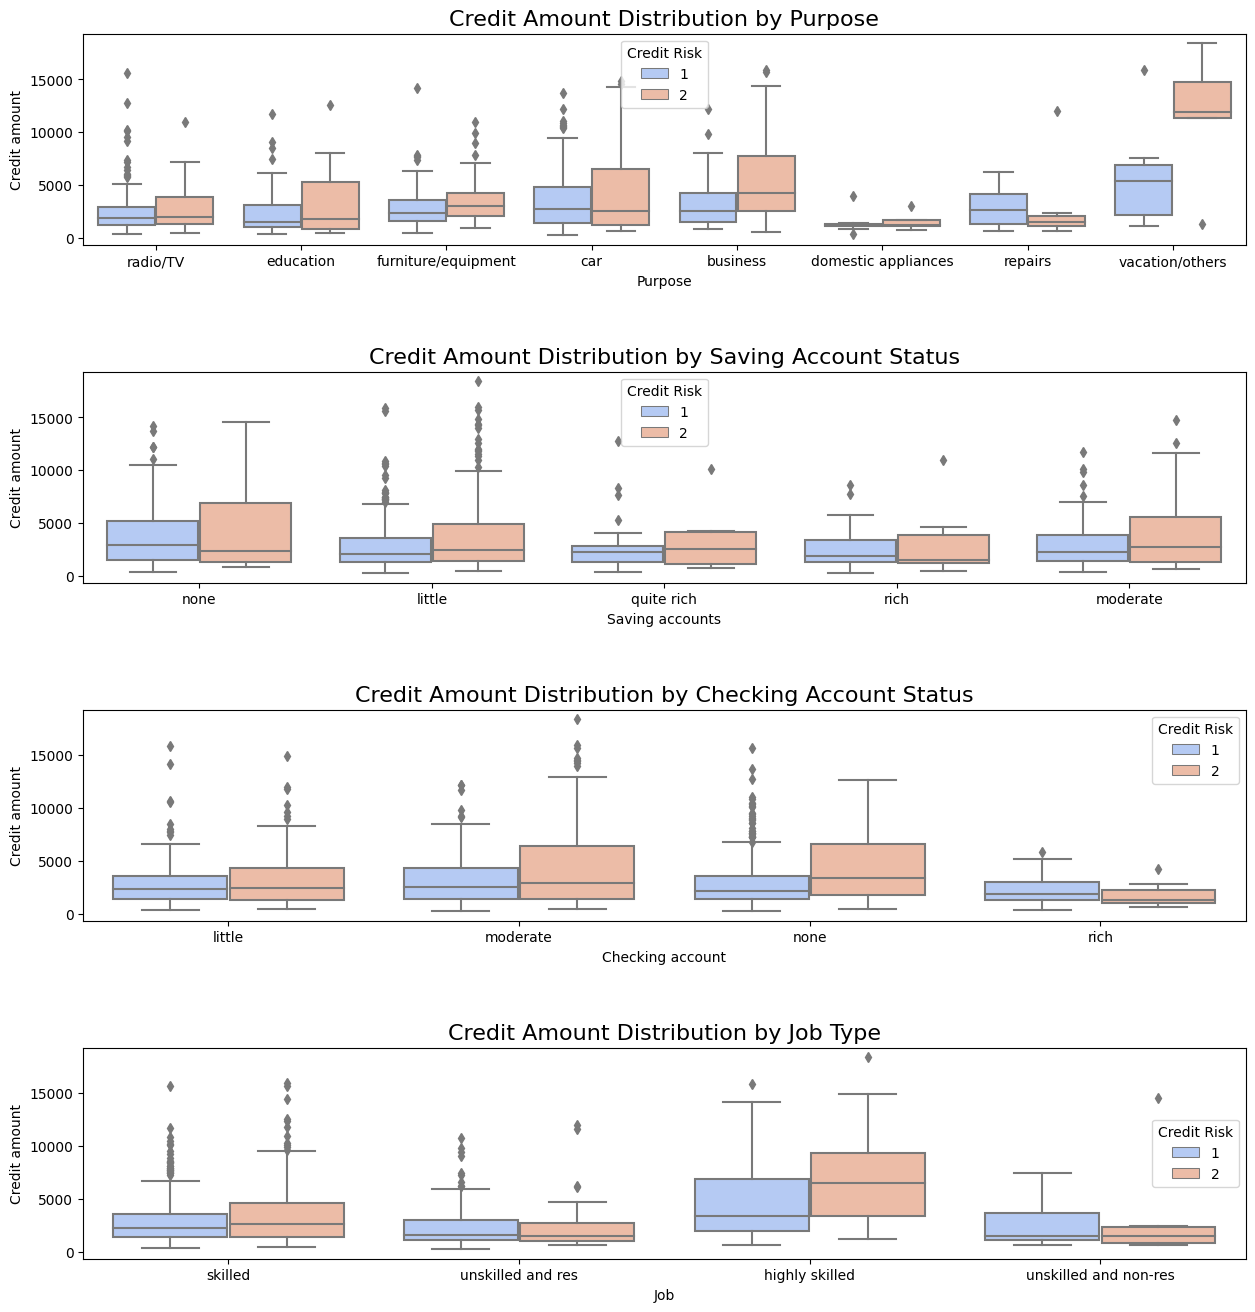

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,25))

sns.boxplot(x="Purpose", y="Credit amount", data=df, hue="Credit Risk", palette="coolwarm", ax=ax1)
sns.boxplot(x="Saving accounts", y="Credit amount", data=df, hue="Credit Risk", palette="coolwarm", ax=ax2)
sns.boxplot(x="Checking account", y="Credit amount", data=df, hue="Credit Risk", palette="coolwarm", ax=ax3)
sns.boxplot(x="Job", y="Credit amount", data=df, hue="Credit Risk", palette="coolwarm", ax=ax4)

ax1.set_title("Credit Amount Distribution by Purpose", fontsize=16)
ax2.set_title("Credit Amount Distribution by Saving Account Status", fontsize=16)
ax3.set_title("Credit Amount Distribution by Checking Account Status", fontsize=16)
ax4.set_title("Credit Amount Distribution by Job Type", fontsize=16)

plt.subplots_adjust(hspace = 0.6, top = 0.6)
plt.show()

## 年龄和贷款期限划分的信用额度分布

- 一般来说，在'age'中，'bad'的金额往往较高，但对于55岁以上的人，这一差距更大。
- 在'duration'方面，'bad' 和 'good' 的金额通常是同步变化的。此外，较大金额的长期贷款更可能被分类为“good”。

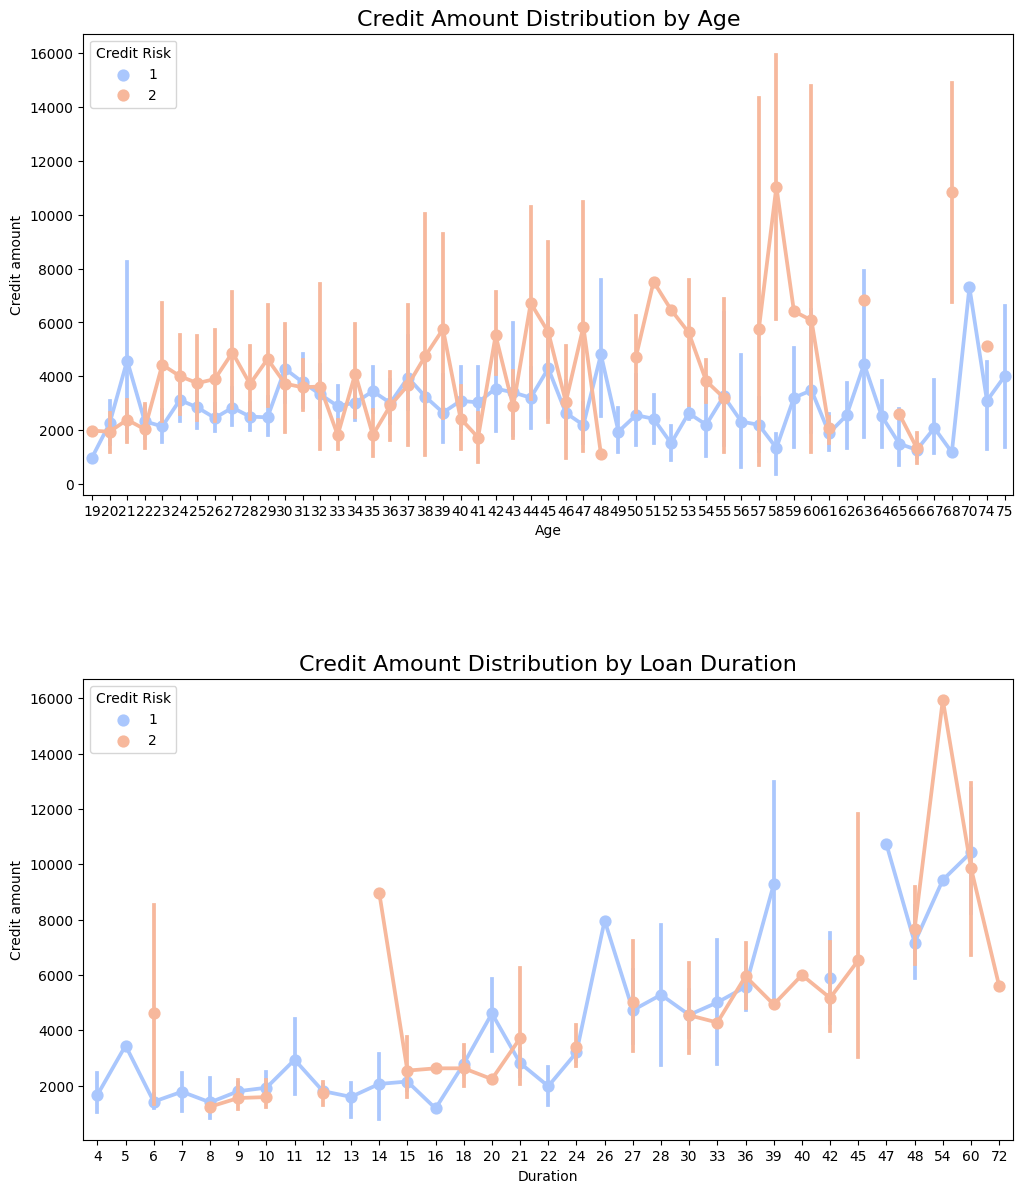

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,14))

sns.pointplot(x="Age", y="Credit amount", data=df, hue="Credit Risk", palette="coolwarm", ax=ax1)
sns.pointplot(x="Duration", y="Credit amount", data=df, hue="Credit Risk", palette="coolwarm", ax=ax2)

ax1.set_title("Credit Amount Distribution by Age", fontsize=16)
ax2.set_title("Credit Amount Distribution by Loan Duration", fontsize=16)

plt.subplots_adjust(wspace = 0.4, hspace = 0.4,top = 0.9)
plt.show()

# 特征工程

In [11]:
# 编码类别变量
dummies_columns = ['Job', 'Purpose', 'Sex', 'Housing', 'Saving accounts', 'Checking account']
for col in dummies_columns:
    df = df.merge(pd.get_dummies(df[col], drop_first=True, prefix=str(col)), left_index=True, right_index=True) 

# 二值编码
# r = {"good":0, "bad": 1}
# df['Credit Risk'] = df['Credit Risk'].map(r)

# drop redundant variables
columns_to_drop = ['Job', 'Purpose','Sex','Housing','Saving accounts','Checking account']
df.drop(columns_to_drop, axis=1, inplace=True)

df.head()

,Age,Credit amount,Duration,Credit Risk,Job_skilled,Job_unskilled and non-res,Job_unskilled and res,Purpose_car,Purpose_domestic appliances,Purpose_education,...,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_none,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_none,Checking account_rich
0,67,1169,6,1,True,False,False,False,False,False,...,True,True,False,False,True,False,False,False,False,False
1,22,5951,48,2,True,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
2,49,2096,12,1,False,False,True,False,False,True,...,True,True,False,False,False,False,False,False,True,False
3,45,7882,42,1,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,53,4870,24,2,True,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False


In [12]:
# 获取信用额度的对数值，而不是直接使用原始的信用额度作为因变量。这将使信用额度分布更接近正态分布。
df['Log_CA'] = np.log(df['Credit amount'])

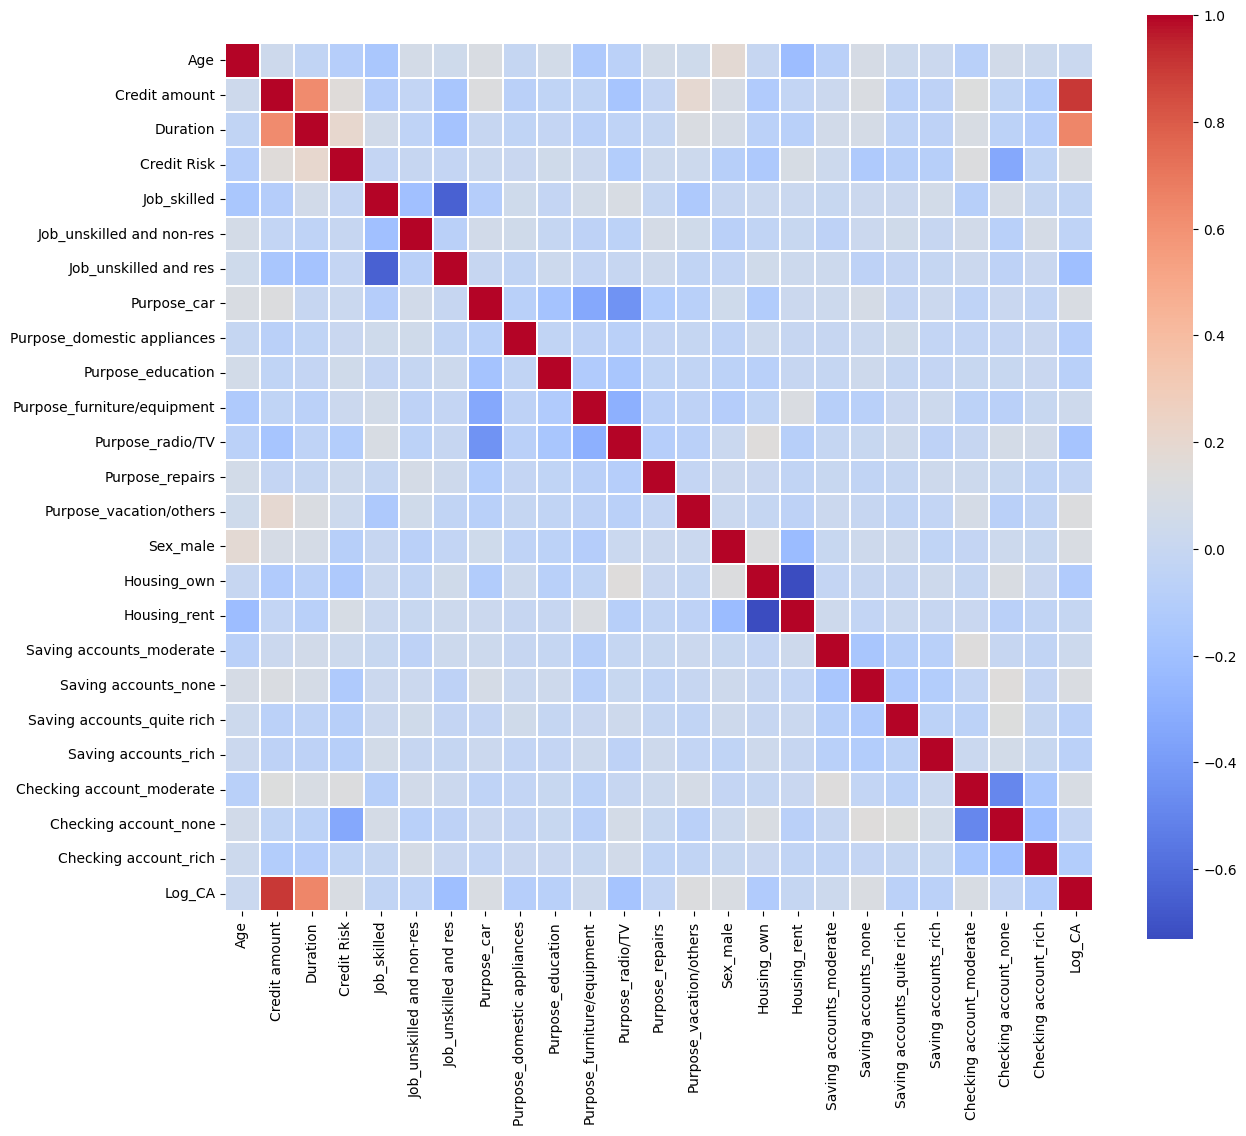

In [13]:
plt.figure(figsize=(14,12))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', cmap='coolwarm')
plt.show()

# Models

In [14]:
X = df.drop(['Credit Risk', 'Credit amount'], axis=1).values
y = df['Credit Risk'].values

In [15]:
# 标准化数值变量
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [16]:
df.head()

,Age,Credit amount,Duration,Credit Risk,Job_skilled,Job_unskilled and non-res,Job_unskilled and res,Purpose_car,Purpose_domestic appliances,Purpose_education,...,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_none,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_none,Checking account_rich,Log_CA
0,67,1169,6,1,True,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,7.063904
1,22,5951,48,2,True,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,8.691315
2,49,2096,12,1,False,False,True,False,False,True,...,True,False,False,False,False,False,False,True,False,7.647786
3,45,7882,42,1,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,8.972337
4,53,4870,24,2,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,8.490849


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 朴素贝叶斯GaussianNB

Naive Bayes Accuracy: 0.680628272251309
Classification Report:
               precision    recall  f1-score   support

           1       0.76      0.77      0.76       128
           2       0.52      0.51      0.51        63

    accuracy                           0.68       191
   macro avg       0.64      0.64      0.64       191
weighted avg       0.68      0.68      0.68       191



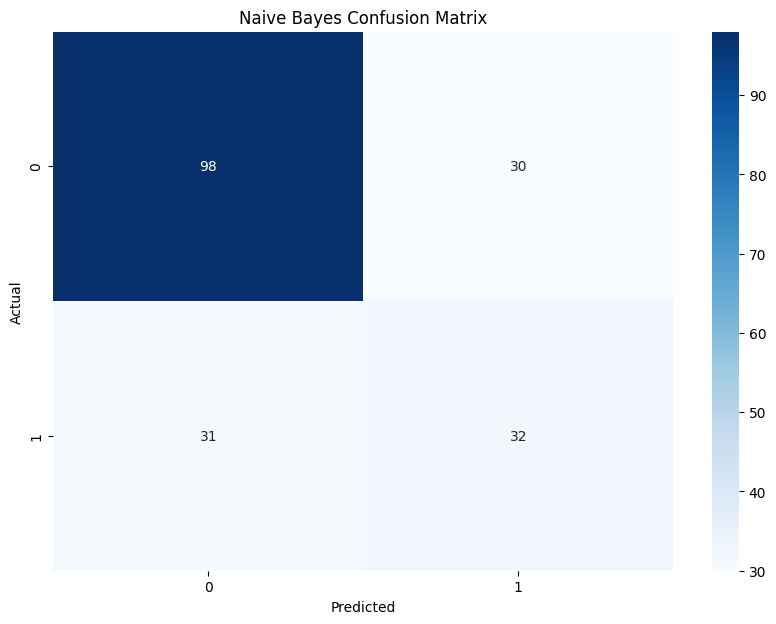

In [18]:
# 训练模型
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)

nb_accuracy = accuracy_score(y_test, nb_predictions)

# 输出性能
print('Naive Bayes Accuracy:', nb_accuracy)
print('Classification Report:\n', classification_report(y_test, nb_predictions))
# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, nb_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 逻辑回归LogisticRegression

LogisticRegression Accuracy: 0.7382198952879581
Classification Report:
               precision    recall  f1-score   support

           1       0.75      0.91      0.82       128
           2       0.69      0.38      0.49        63

    accuracy                           0.74       191
   macro avg       0.72      0.65      0.66       191
weighted avg       0.73      0.74      0.71       191



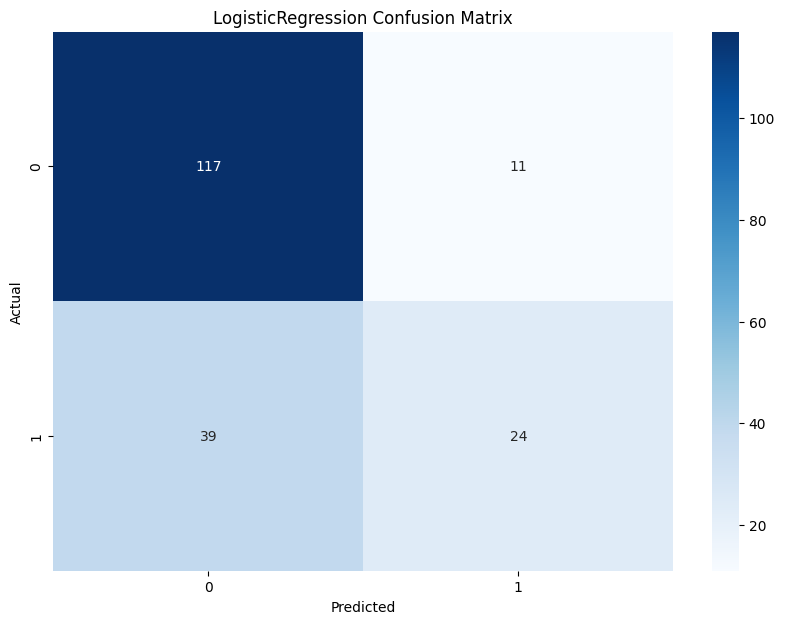

In [19]:
from sklearn.linear_model import LogisticRegression, LinearRegression
log = LogisticRegression()
log.fit(X_train, y_train)
log_predictions = log.predict(X_test)
log_accuracy = accuracy_score(log_predictions, y_test)

print('LogisticRegression Accuracy:', log_accuracy)
print('Classification Report:\n',classification_report(y_test, log_predictions))

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, log_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('LogisticRegression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 决策树DecisionTree

Decision Tree Accuracy: 0.6335078534031413
Classification Report:
               precision    recall  f1-score   support

           1       0.73      0.73      0.73       128
           2       0.44      0.44      0.44        63

    accuracy                           0.63       191
   macro avg       0.59      0.59      0.59       191
weighted avg       0.63      0.63      0.63       191



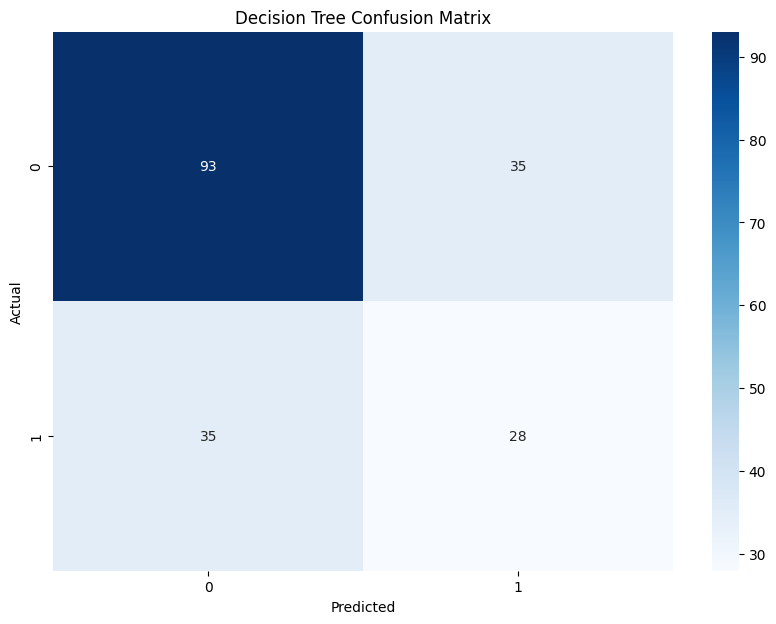

In [20]:
# 训练模型
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)

# 输出性能
print('Decision Tree Accuracy:', dt_accuracy)
print('Classification Report:\n', classification_report(y_test, dt_predictions))

# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, dt_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 随机森林RandomForest

Random Forest Accuracy: 0.7172774869109948
Classification Report:
               precision    recall  f1-score   support

           1       0.74      0.88      0.81       128
           2       0.62      0.38      0.47        63

    accuracy                           0.72       191
   macro avg       0.68      0.63      0.64       191
weighted avg       0.70      0.72      0.70       191



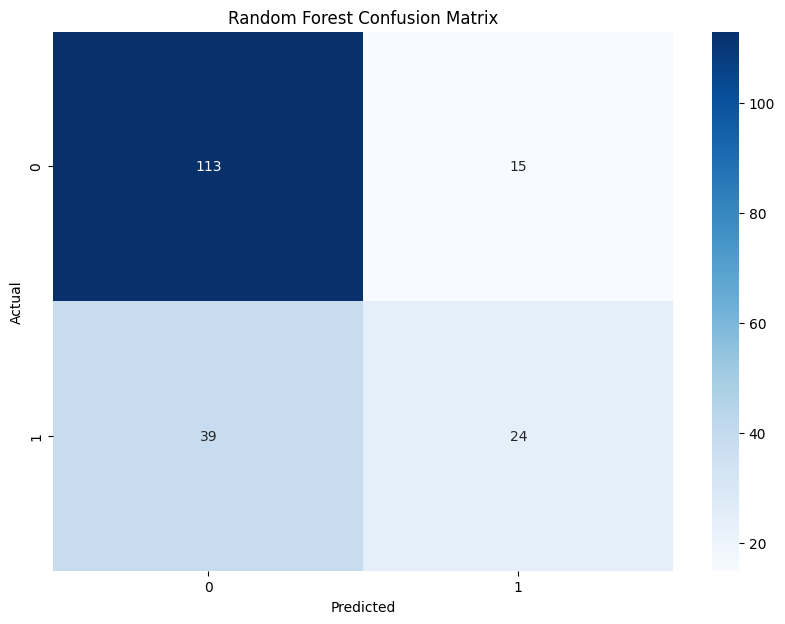

In [21]:
# 训练模型
rf_model = RandomForestClassifier(max_depth=9, max_features=15, min_samples_leaf=5, n_estimators=25)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

# 输出性能
print('Random Forest Accuracy:', rf_accuracy)
print('Classification Report:\n', classification_report(y_test, rf_predictions))

# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 支持向量机SVM

SVM Accuracy: 0.7382198952879581
Classification Report:
               precision    recall  f1-score   support

           1       0.75      0.91      0.82       128
           2       0.69      0.38      0.49        63

    accuracy                           0.74       191
   macro avg       0.72      0.65      0.66       191
weighted avg       0.73      0.74      0.71       191



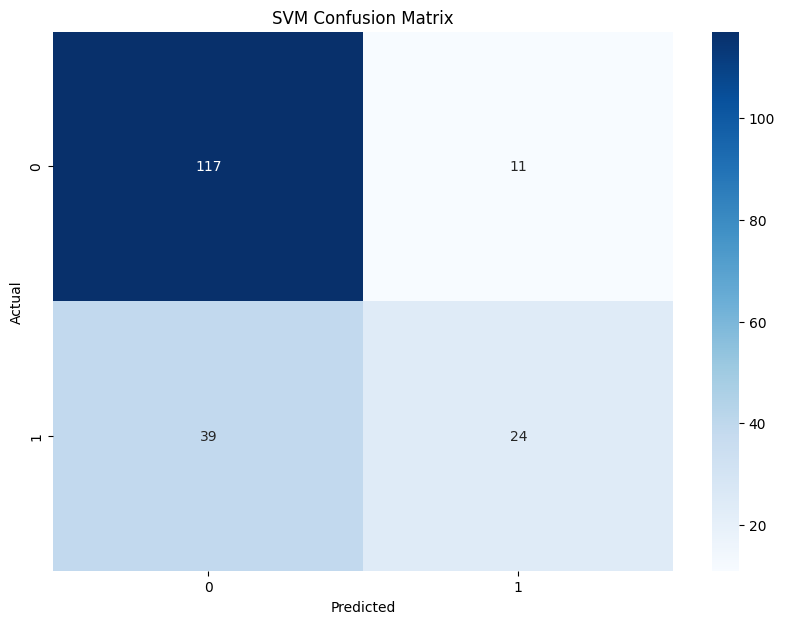

In [22]:
# 训练模型
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)

# 输出性能
print('SVM Accuracy:', svm_accuracy)
print('Classification Report:\n', classification_report(y_test, svm_predictions))

# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, svm_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## KNN

KNN Accuracy: 0.7015706806282722
Classification Report:
               precision    recall  f1-score   support

           1       0.74      0.87      0.80       128
           2       0.57      0.37      0.45        63

    accuracy                           0.70       191
   macro avg       0.66      0.62      0.62       191
weighted avg       0.68      0.70      0.68       191



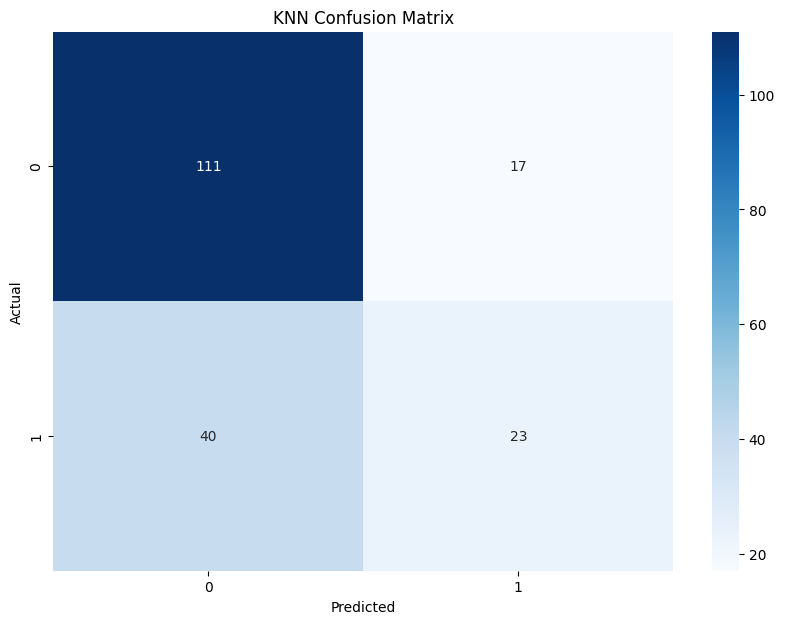

In [23]:
# 训练模型
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)

# 输出性能
print('KNN Accuracy:', knn_accuracy)
print('Classification Report:\n', classification_report(y_test, knn_predictions))

# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, knn_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## ANN（Artificial Neural Network，人工神经网络）

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


ANN Accuracy: 0.7329842931937173
Classification Report:
               precision    recall  f1-score   support

           1       0.78      0.84      0.81       128
           2       0.61      0.52      0.56        63

    accuracy                           0.73       191
   macro avg       0.70      0.68      0.69       191
weighted avg       0.72      0.73      0.73       191



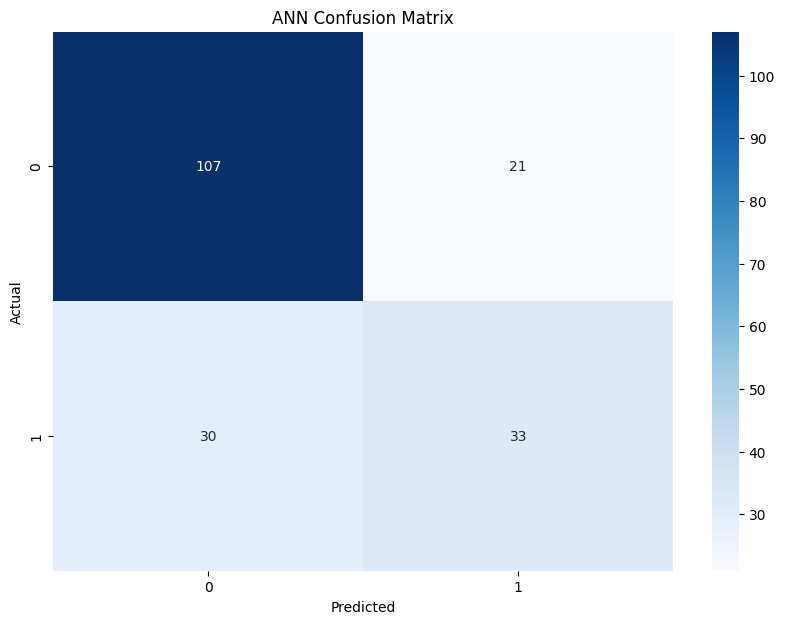

In [24]:
# 训练模型
ann_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
ann_model.fit(X_train, y_train)
ann_predictions = ann_model.predict(X_test)
ann_accuracy = accuracy_score(y_test, ann_predictions)

# 输出性能
print('ANN Accuracy:', ann_accuracy)
print('Classification Report:\n', classification_report(y_test, ann_predictions))

# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, ann_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('ANN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## LSTM（Long Short-Term Memory，长短期记忆）

Epoch 1/20
24/24 [==============================] - 3s 3ms/step - loss: 0.6490 - accuracy: 0.4509
Epoch 2/20
24/24 [==============================] - 0s 3ms/step - loss: 0.5177 - accuracy: 0.6055
Epoch 3/20
24/24 [==============================] - 0s 3ms/step - loss: 0.3692 - accuracy: 0.6841
Epoch 4/20
24/24 [==============================] - 0s 3ms/step - loss: 0.1935 - accuracy: 0.6972
Epoch 5/20
24/24 [==============================] - 0s 3ms/step - loss: -0.0077 - accuracy: 0.6986
Epoch 6/20
24/24 [==============================] - 0s 3ms/step - loss: -0.2211 - accuracy: 0.6999
Epoch 7/20
24/24 [==============================] - 0s 3ms/step - loss: -0.4430 - accuracy: 0.7012
Epoch 8/20
24/24 [==============================] - 0s 3ms/step - loss: -0.6685 - accuracy: 0.7038
Epoch 9/20
24/24 [==============================] - 0s 3ms/step - loss: -0.8967 - accuracy: 0.7038
Epoch 10/20
24/24 [==============================] - 0s 3ms/step - loss: -1.1340 - accuracy: 0.7038
Epoch 11/20
2

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


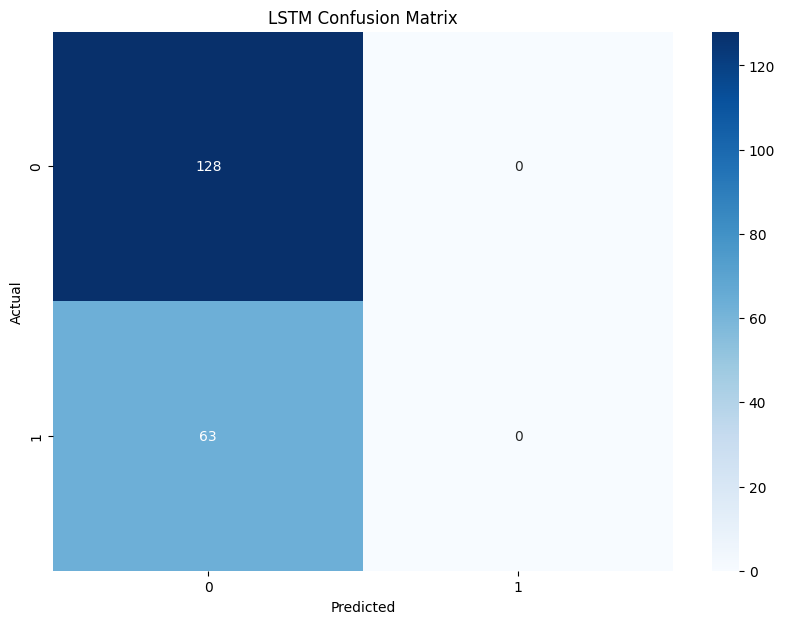

In [25]:
# 重新调整数据形状
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 训练模型
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32)

# 预测
lstm_predictions = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")
lstm_accuracy = accuracy_score(y_test, lstm_predictions)

# 输出性能
print('LSTM Accuracy:', lstm_accuracy)
print('Classification Report:\n', classification_report(y_test, lstm_predictions))

# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, lstm_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## RNN

Epoch 1/20
24/24 [==============================] - 1s 3ms/step - loss: 0.6551 - accuracy: 0.3355
Epoch 2/20
24/24 [==============================] - 0s 3ms/step - loss: 0.4524 - accuracy: 0.4076
Epoch 3/20
24/24 [==============================] - 0s 3ms/step - loss: 0.2738 - accuracy: 0.4718
Epoch 4/20
24/24 [==============================] - 0s 2ms/step - loss: 0.1051 - accuracy: 0.5203
Epoch 5/20
24/24 [==============================] - 0s 2ms/step - loss: -0.0699 - accuracy: 0.5662
Epoch 6/20
24/24 [==============================] - 0s 3ms/step - loss: -0.2482 - accuracy: 0.6029
Epoch 7/20
24/24 [==============================] - 0s 2ms/step - loss: -0.4394 - accuracy: 0.6409
Epoch 8/20
24/24 [==============================] - 0s 18ms/step - loss: -0.6293 - accuracy: 0.6619
Epoch 9/20
24/24 [==============================] - 0s 3ms/step - loss: -0.8427 - accuracy: 0.6645
Epoch 10/20
24/24 [==============================] - 0s 2ms/step - loss: -1.0677 - accuracy: 0.6750
Epoch 11/20


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

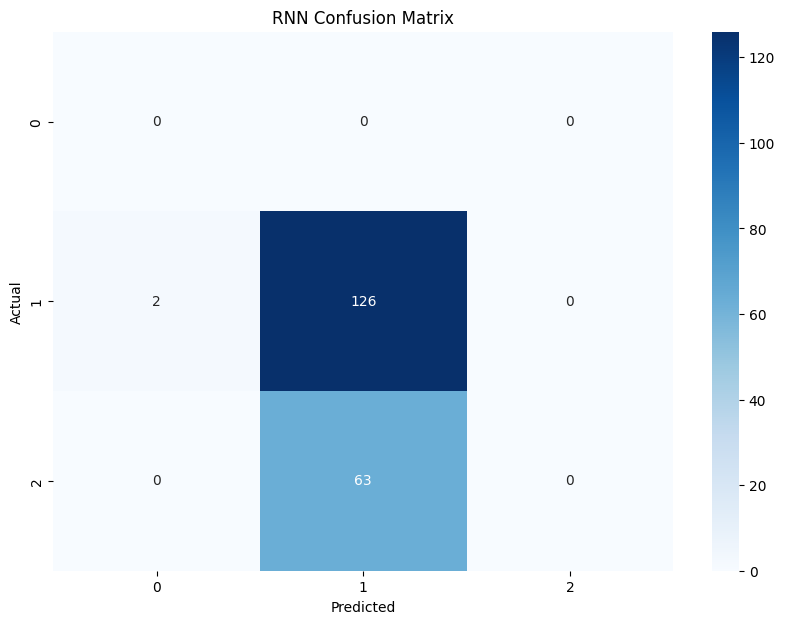

In [26]:
# 训练模型
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32)

# 预测
rnn_predictions = (rnn_model.predict(X_test_lstm) > 0.5).astype("int32")
rnn_accuracy = accuracy_score(y_test, rnn_predictions)

# 输出性能
print('RNN Accuracy:', rnn_accuracy)
print('Classification Report:\n', classification_report(y_test, rnn_predictions))

# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, rnn_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('RNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Ensemble_Voting

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Ensemble Voting Accuracy: 0.7172774869109948
Classification Report:
               precision    recall  f1-score   support

           1       0.74      0.90      0.81       128
           2       0.63      0.35      0.45        63

    accuracy                           0.72       191
   macro avg       0.68      0.62      0.63       191
weighted avg       0.70      0.72      0.69       191



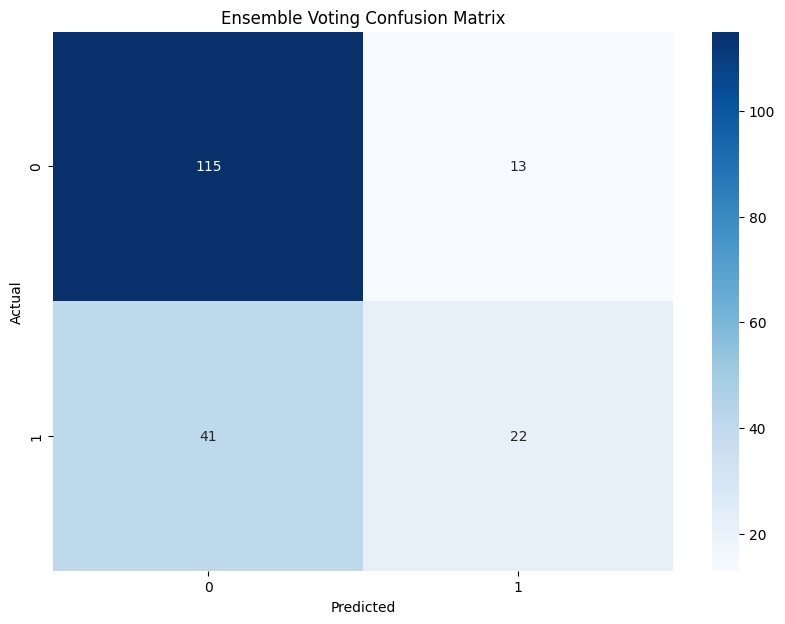

In [27]:
from sklearn.ensemble import VotingClassifier
# 训练模型
ensemble_model = VotingClassifier(estimators=[
    ('nb', nb_model), ('dt', dt_model), ('rf', rf_model), ('svm', svm_model), ('knn', knn_model), ('ann', ann_model)
], voting='hard')
ensemble_model.fit(X_train, y_train)
ensemble_predictions = ensemble_model.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)

# 输出性能
print('Ensemble Voting Accuracy:', ensemble_accuracy)
print('Classification Report:\n', classification_report(y_test, ensemble_predictions))

# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, ensemble_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Ensemble Voting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Ensemble_stacking

Stacking Accuracy: 0.6858638743455497
Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.87      0.79       128
           2       0.54      0.32      0.40        63

    accuracy                           0.69       191
   macro avg       0.63      0.59      0.59       191
weighted avg       0.66      0.69      0.66       191



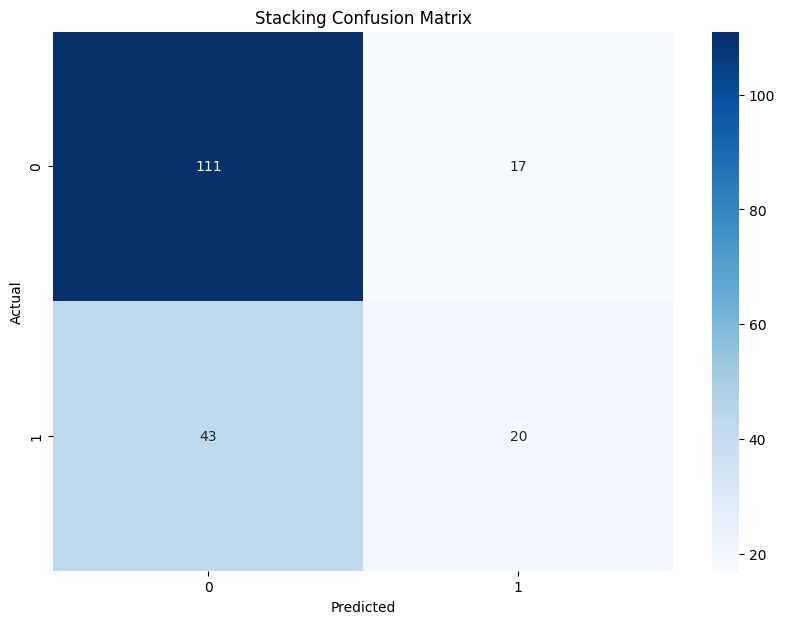

In [28]:
from sklearn.ensemble import StackingClassifier
# 训练模型
stacking_model = StackingClassifier(estimators=[
    ('nb', nb_model), ('dt', dt_model), ('rf', rf_model), ('svm', svm_model), ('knn', knn_model)
], final_estimator=RandomForestClassifier())
stacking_model.fit(X_train, y_train)
stacking_predictions = stacking_model.predict(X_test)
stacking_accuracy = accuracy_score(y_test, stacking_predictions)

# 输出性能
print('Stacking Accuracy:', stacking_accuracy)
print('Classification Report:\n', classification_report(y_test, stacking_predictions))

# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, stacking_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Stacking Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Ensemble_boosting

Boosting Accuracy: 0.7120418848167539
Classification Report:
               precision    recall  f1-score   support

           1       0.74      0.88      0.80       128
           2       0.61      0.37      0.46        63

    accuracy                           0.71       191
   macro avg       0.67      0.62      0.63       191
weighted avg       0.69      0.71      0.69       191



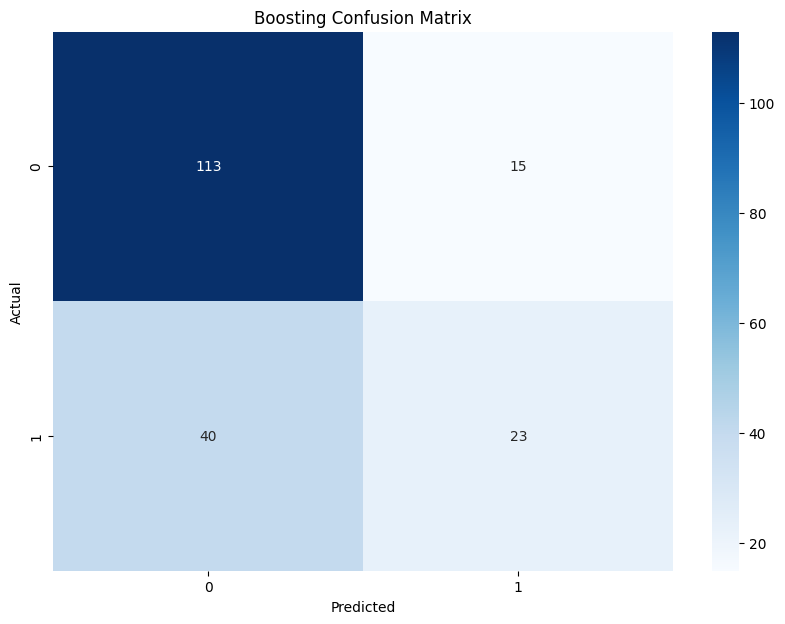

In [29]:
# 训练模型
boosting_model = AdaBoostClassifier(n_estimators=100)
boosting_model.fit(X_train, y_train)
boosting_predictions = boosting_model.predict(X_test)
boosting_accuracy = accuracy_score(y_test, boosting_predictions)


# 输出性能
print('Boosting Accuracy:', boosting_accuracy)
print('Classification Report:\n', classification_report(y_test, boosting_predictions))

# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, boosting_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Ensemble_bagging

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Accuracy: 0.7120418848167539
Classification Report:
               precision    recall  f1-score   support

           1       0.75      0.86      0.80       128
           2       0.59      0.41      0.49        63

    accuracy                           0.71       191
   macro avg       0.67      0.64      0.64       191
weighted avg       0.70      0.71      0.70       191



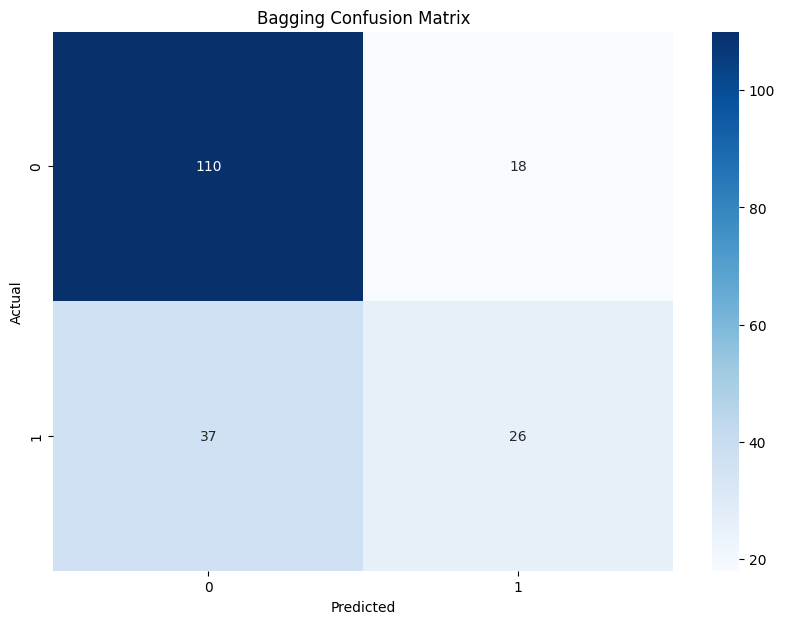

In [30]:
from sklearn.ensemble import BaggingClassifier
# 训练模型
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100,
random_state=42)
bagging_model.fit(X_train, y_train)
bagging_predictions = bagging_model.predict(X_test)
bagging_accuracy = accuracy_score(y_test, bagging_predictions)

# 输出性能
print('Bagging Accuracy:', bagging_accuracy)
print('Classification Report:\n', classification_report(y_test, bagging_predictions))

# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, bagging_predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Bagging Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Accuracy & ROC

In [31]:
show_predictions = []
# 预测结果字典
predictions = {
    'Naive Bayes': nb_accuracy,
    'Logistic Regression': log_accuracy,
    'Decision Tree': dt_accuracy,
    'Random Forest': rf_accuracy,
    'SVM': svm_accuracy,
    'KNN': knn_accuracy,
    'ANN': ann_accuracy,
    'LSTM': lstm_accuracy,
    'RNN': rnn_accuracy,
    'Voting Ensemble': ensemble_accuracy,
    'Stacking Ensemble': stacking_accuracy,
    'Boosting Ensemble': boosting_accuracy,
    'Bagging Ensemble': bagging_accuracy
}
for key,value in predictions.items():
    show_predictions.append({'models': key, 'predictions': value})
show_predictions_table = pd.DataFrame(show_predictions)
show_predictions_table.set_index('models', inplace=True)
print(show_predictions_table)

                     predictions
models                          
Naive Bayes             0.680628
Logistic Regression     0.738220
Decision Tree           0.633508
Random Forest           0.717277
SVM                     0.738220
KNN                     0.701571
ANN                     0.732984
LSTM                    0.670157
RNN                     0.659686
Voting Ensemble         0.717277
Stacking Ensemble       0.685864
Boosting Ensemble       0.712042
Bagging Ensemble        0.712042


In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 初始化结果列表
results = []

# 预测结果字典
predictions = {
    'Naive Bayes': nb_predictions,
    'Logistic Regression': log_predictions,
    'Decision Tree': dt_predictions,
    'Random Forest': rf_predictions,
    'SVM': svm_predictions,
    'KNN': knn_predictions,
    'ANN': ann_predictions,
    'LSTM': lstm_predictions,
    'RNN': rnn_predictions,
    'Voting Ensemble': ensemble_predictions,
    'Stacking Ensemble': stacking_predictions,
    'Boosting Ensemble': boosting_predictions,
    'Bagging Ensemble': bagging_predictions
}

# 计算ROC曲线和AUC
for key in predictions:
    fpr, tpr, _ = roc_curve(y_test, predictions[key], pos_label=2)
    auc = roc_auc_score(y_test, predictions[key])
    results.append({'models': key, 'fpr': fpr, 'tpr': tpr, 'auc': auc})

results_table = pd.DataFrame(results)
results_table.set_index('models', inplace=True)
print(results_table)

                                       fpr                              tpr  \
models                                                                        
Naive Bayes           [0.0, 0.234375, 1.0]   [0.0, 0.5079365079365079, 1.0]   
Logistic Regression  [0.0, 0.0859375, 1.0]  [0.0, 0.38095238095238093, 1.0]   
Decision Tree        [0.0, 0.2734375, 1.0]   [0.0, 0.4444444444444444, 1.0]   
Random Forest        [0.0, 0.1171875, 1.0]  [0.0, 0.38095238095238093, 1.0]   
SVM                  [0.0, 0.0859375, 1.0]  [0.0, 0.38095238095238093, 1.0]   
KNN                  [0.0, 0.1328125, 1.0]  [0.0, 0.36507936507936506, 1.0]   
ANN                  [0.0, 0.1640625, 1.0]   [0.0, 0.5238095238095238, 1.0]   
LSTM                            [0.0, 1.0]                       [0.0, 1.0]   
RNN                   [0.0, 0.984375, 1.0]                  [0.0, 1.0, 1.0]   
Voting Ensemble      [0.0, 0.1015625, 1.0]   [0.0, 0.3492063492063492, 1.0]   
Stacking Ensemble    [0.0, 0.1328125, 1.0]  [0.0, 0.

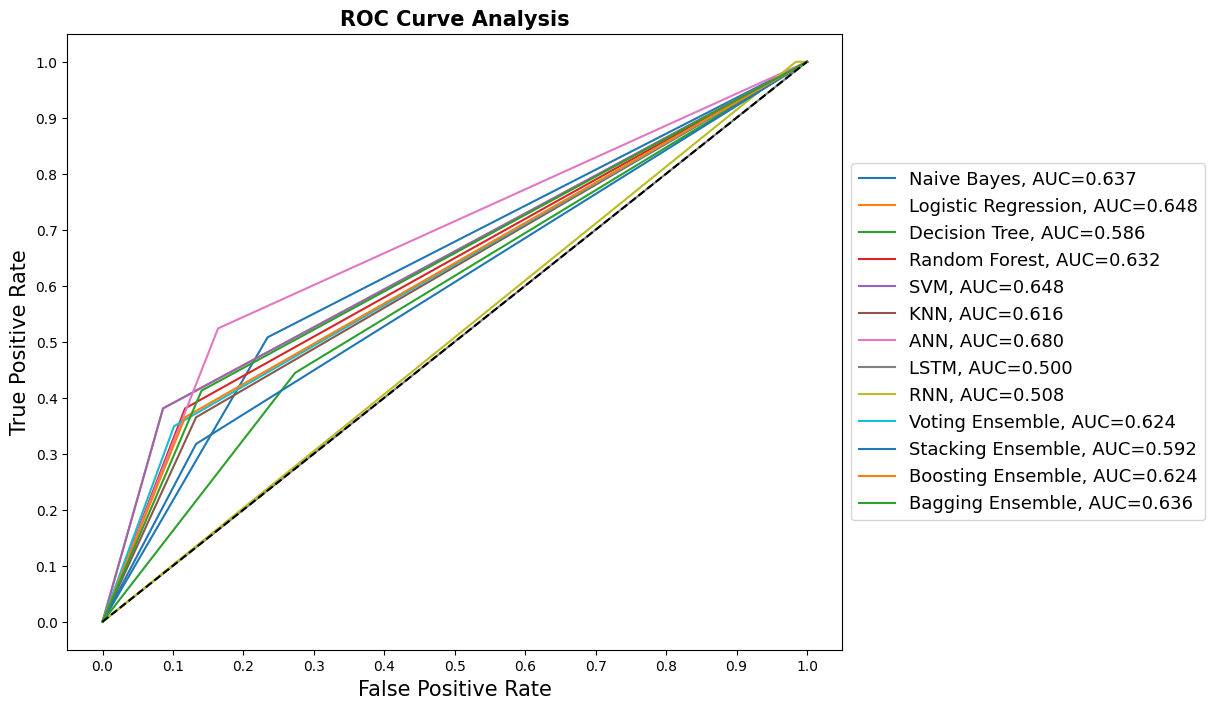

In [33]:
# 绘制ROC曲线
fig = plt.figure(figsize=(10, 8))

for i in results_table.index:
    plt.plot(results_table.loc[i]['fpr'], 
             results_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, results_table.loc[i]['auc']))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
#plt.legend(prop={'size':13}, loc='lower right')
plt.legend(prop={'size': 13}, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()